In [1]:
import pandas as pd
import numpy as np
import torch
from transformers import BertTokenizer, BertModel
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [2]:
data = pd.read_csv('/kaggle/input/filtered-and-translated-nlp/filr.csv')

In [3]:
X = data['Translated']
y = data['Label']

In [4]:
X

0      After hacking state TV by replacing propaganda...
1      #flowers #lovers\nMake love not war.\nMarc Cha...
2      If only we all showed more love and understand...
3      Who are the soldiers we see in the videos? Are...
4      I didn't think #Salvini could make his positio...
                             ...                        
475    If I write that Ms. #Zelensky was allegedly sp...
476    #Zelensky and his wife #OlenaZelenska bought a...
477    ALL UNITED AGAINST DRAGONS\nAGAINST WAR\nAGAIN...
478    ALL UNITED AGAINST DRAGONS\nAGAINST WAR\nAGAIN...
479    ALL UNITED AGAINST DRAGONS\nAGAINST WAR\nAGAIN...
Name: Translated, Length: 480, dtype: object

In [5]:
y

0      1
1      2
2      2
3      2
4      1
      ..
475    1
476    0
477    2
478    2
479    2
Name: Label, Length: 480, dtype: int64

In [6]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [7]:
def generate_embeddings(texts):
    model.eval()
    embeddings = []
    with torch.no_grad():
        for text in texts:
            inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
            outputs = model(**inputs)
            pooled_output = outputs.pooler_output.squeeze().numpy()
            embeddings.append(pooled_output)
    return np.array(embeddings)

# Generate embeddings
print("Generating BERT embeddings...")
X_embeddings = generate_embeddings(X)

Generating BERT embeddings...


In [8]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_embeddings, y, test_size=0.2, random_state=42)

# Train an SVM classifier
print("Training SVM...")
clf = SVC(kernel='linear')
clf.fit(X_train, y_train)

# Predict and evaluate
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Training SVM...
Accuracy: 41.67%


# Follow a repo 
For finetuning

In [9]:
!pip install transformers

In [10]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast

# specify GPU
device = torch.device("cuda")

In [11]:
data = pd.read_csv('/kaggle/input/filtered-and-translated-nlp/filr.csv')

In [12]:
X = data['Translated']
y = data['Label']

In [13]:
y.value_counts(normalize = True)

Label
2    0.431250
1    0.235417
3    0.172917
0    0.160417
Name: proportion, dtype: float64

In [14]:
train_text, temp_text, train_labels, temp_labels = train_test_split(X, y, 
                                                                    random_state=2018, 
                                                                    test_size=0.3, 
                                                                    stratify=y)

# we will use temp_text and temp_labels to create validation and test set
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
                                                                random_state=2018, 
                                                                test_size=0.5, 
                                                                stratify=temp_labels)

In [15]:
bert = AutoModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

In [16]:
# sample data
text = ["this is a bert model tutorial", "we will fine-tune a bert model"]

# encode text
sent_id = tokenizer.batch_encode_plus(text, padding=True, return_token_type_ids=False)

In [17]:
print(sent_id)

{'input_ids': [[101, 2023, 2003, 1037, 14324, 2944, 14924, 4818, 102, 0], [101, 2057, 2097, 2986, 1011, 8694, 1037, 14324, 2944, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


# Tokenization

<Axes: >

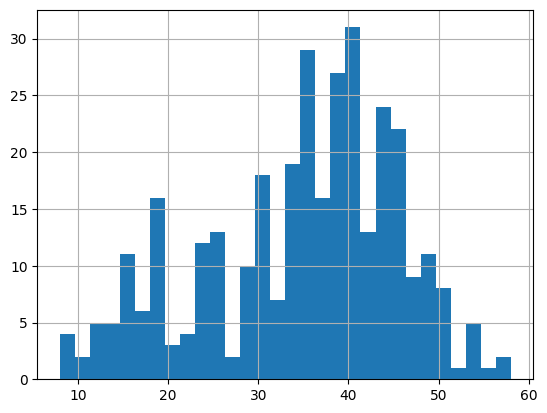

In [18]:
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)

In [19]:
max_seq_len = max(seq_len)

In [20]:
max_seq_len

58

In [21]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2673: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [22]:

# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

# for validation set
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

# for test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

In [23]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

In [24]:


# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

In [25]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
      
      super(BERT_Arch, self).__init__()

      self.bert = bert 
      
      # dropout layer
      self.dropout = nn.Dropout(0.1)
      
      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,512)
      
      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,4)

      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):
    # Pass the inputs to the model
        outputs = self.bert(sent_id, attention_mask=mask)
        cls_hs = outputs.pooler_output
        
        # Pass through fully connected layers
        x = self.fc1(cls_hs)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.softmax(x)
    
        return x

In [26]:
print(device)

cuda


In [27]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)

In [28]:

# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(), lr = 1e-3)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [29]:

from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_wts = compute_class_weight(class_weight='balanced', classes=np.unique(train_labels), y=train_labels)

print(class_wts)

[1.55555556 1.06329114 0.57931034 1.44827586]


In [30]:

# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)

# loss function
cross_entropy  = nn.NLLLoss(weight=weights) 

# number of training epochs
epochs = 10

In [31]:
# function to train the model
def train():
  
  model.train()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save model predictions
  total_preds=[]
  
  # iterate over batches
  for step,batch in enumerate(train_dataloader):
    
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]
 
    sent_id, mask, labels = batch

    # clear previously calculated gradients 
    model.zero_grad()        

    # get model predictions for the current batch
    preds = model(sent_id, mask)

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds

In [32]:
# function for evaluating the model
def evaluate():
  
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
      elapsed = format_time(time.time() - t0)
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

In [33]:

# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 10

Evaluating...

Training Loss: 1.582
Validation Loss: 1.349

 Epoch 2 / 10

Evaluating...

Training Loss: 1.437
Validation Loss: 1.392

 Epoch 3 / 10

Evaluating...

Training Loss: 1.372
Validation Loss: 1.420

 Epoch 4 / 10

Evaluating...

Training Loss: 1.391
Validation Loss: 1.344

 Epoch 5 / 10

Evaluating...

Training Loss: 1.418
Validation Loss: 1.371

 Epoch 6 / 10

Evaluating...

Training Loss: 1.376
Validation Loss: 1.349

 Epoch 7 / 10

Evaluating...

Training Loss: 1.326
Validation Loss: 1.327

 Epoch 8 / 10

Evaluating...

Training Loss: 1.310
Validation Loss: 1.373

 Epoch 9 / 10

Evaluating...

Training Loss: 1.376
Validation Loss: 1.383

 Epoch 10 / 10

Evaluating...

Training Loss: 1.345
Validation Loss: 1.368


In [34]:


# get predictions for test data
with torch.no_grad():
  preds = model(test_seq.to(device), test_mask.to(device))
  preds = preds.detach().cpu().numpy()
     

# model's performance
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.26      0.75      0.38        12
           1       0.00      0.00      0.00        17
           2       0.50      0.45      0.47        31
           3       0.44      0.33      0.38        12

    accuracy                           0.38        72
   macro avg       0.30      0.38      0.31        72
weighted avg       0.33      0.38      0.33        72



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# ChatGPT

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Custom Dataset
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, index):
        text = self.texts.iloc[index]  # Using .iloc for safe indexing
        label = self.labels.iloc[index]
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_len, return_tensors='pt')

        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'label': torch.tensor(label, dtype=torch.long)
        }


# Define Model
class BERTClassifier(nn.Module):
    def __init__(self, num_classes=4):
        super(BERTClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.fc = nn.Linear(768, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        logits = self.fc(outputs.pooler_output)
        return logits

# Prepare Data
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

train_dataset = TextDataset(X_train, y_train, tokenizer)
test_dataset = TextDataset(X_test, y_test, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Initialize Model and Parameters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BERTClassifier(num_classes=4).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=2e-5)

# Training Loop
def train_model(epochs=3):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch in train_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
        print(f"Epoch {epoch + 1}, Loss: {total_loss / len(train_loader)}")

# Evaluation
def evaluate_model():
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask)
            predictions = torch.argmax(outputs, dim=1)
            all_preds.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Run Training and Evaluation
train_model(25)
evaluate_model()


Epoch 1, Loss: 1.3202871928612392
Epoch 2, Loss: 1.1803770437836647
Epoch 3, Loss: 1.0171967794497807
Epoch 4, Loss: 0.776843490699927
Epoch 5, Loss: 0.5988089914123217
Epoch 6, Loss: 0.5111452552179495
Epoch 7, Loss: 0.3892643637955189
Epoch 8, Loss: 0.2932945806533098
Epoch 9, Loss: 0.22148984453330436
Epoch 10, Loss: 0.14605277481799325
Epoch 11, Loss: 0.11839799738178651
Epoch 12, Loss: 0.08262243463347356
Epoch 13, Loss: 0.06385140710820754
Epoch 14, Loss: 0.051120028753454484
Epoch 15, Loss: 0.05385881934004525
Epoch 16, Loss: 0.04409429019627472
Epoch 17, Loss: 0.032616524530264236
Epoch 18, Loss: 0.02854304830543697
Epoch 19, Loss: 0.03043265885207802
Epoch 20, Loss: 0.025352997045653563
Epoch 21, Loss: 0.025301651699313272
Epoch 22, Loss: 0.02350107211774836
Epoch 23, Loss: 0.018318536012278248
Epoch 24, Loss: 0.02259548307241251
Epoch 25, Loss: 0.02261593899068733
Test Accuracy: 46.88%


In [22]:
import os

def save_model(model, path='/kaggle/working/model_state_dict.pt'):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    torch.save(model.state_dict(), path)
    print(f"Model state dict saved to {path}")


In [23]:
save_model(model)

Model state dict saved to /kaggle/working/model_state_dict.pt


In [24]:
def save_tokenizer(tokenizer, path='/kaggle/working/tokenizer'):
    os.makedirs(path, exist_ok=True)
    tokenizer.save_pretrained(path)
    print(f"Tokenizer saved to {path}")


In [25]:
save_tokenizer(tokenizer)

Tokenizer saved to /kaggle/working/tokenizer


In [26]:
import numpy as np

def generate_embeddings(texts, tokenizer, model, batch_size=16, max_len=512):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()

    embeddings = []

    with torch.no_grad():
        for i in range(0, len(texts), batch_size):
            batch_texts = texts[i:i+batch_size]

            inputs = tokenizer(batch_texts, padding=True, truncation=True, max_length=max_len, return_tensors='pt')
            input_ids = inputs['input_ids'].to(device)
            attention_mask = inputs['attention_mask'].to(device)
            
            outputs = model.bert(input_ids=input_ids, attention_mask=attention_mask)

            # If pooler_output is available, use it; otherwise, use mean of last hidden state
            if hasattr(outputs, 'pooler_output'):
                batch_embeddings = outputs.pooler_output.cpu().numpy()
            else:
                batch_embeddings = outputs.last_hidden_state.mean(dim=1).cpu().numpy()

            embeddings.extend(batch_embeddings)
    
    return np.array(embeddings)


In [27]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Assuming X_train, X_test, y_train, y_test are available
X_train_embeddings = generate_embeddings(X_train.tolist(), tokenizer, model)
X_test_embeddings = generate_embeddings(X_test.tolist(), tokenizer, model)

# Train the SVM
svm_classifier = SVC(kernel='linear', class_weight = 'balanced')
svm_classifier.fit(X_train_embeddings, y_train)

# Predict and Evaluate
y_pred = svm_classifier.predict(X_test_embeddings)
accuracy = accuracy_score(y_test, y_pred)

print(f"Test Accuracy with SVM: {accuracy * 100:.2f}%")


Test Accuracy with SVM: 43.75%


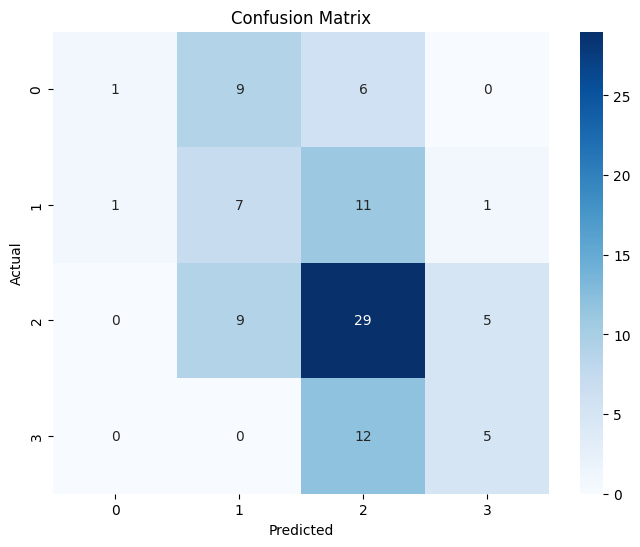

Classification Report:

              precision    recall  f1-score   support

           0       0.50      0.06      0.11        16
           1       0.28      0.35      0.31        20
           2       0.50      0.67      0.57        43
           3       0.45      0.29      0.36        17

    accuracy                           0.44        96
   macro avg       0.43      0.35      0.34        96
weighted avg       0.45      0.44      0.40        96

AUC-ROC is not applicable for multi-class classification.


In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve

# Predict using SVM
y_pred = svm_classifier.predict(X_test_embeddings)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print("Classification Report:\n")
print(classification_report(y_test, y_pred))

# AUC-ROC Score
if len(set(y_test)) <= 2:
    auc_score = roc_auc_score(y_test, svm_classifier.decision_function(X_test_embeddings))
    print(f"AUC-ROC Score: {auc_score:.2f}")

    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(y_test, svm_classifier.decision_function(X_test_embeddings))
    plt.figure(figsize=(8,6))
    plt.plot(fpr, tpr, color='blue', label=f"AUC = {auc_score:.2f}")
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.show()
else:
    print("AUC-ROC is not applicable for multi-class classification.")


In [29]:
print('hi')

hi


In [30]:
misclassified_indices = np.where(y_test != y_pred)[0]
for idx in misclassified_indices[:10]:  # Inspect first 10 misclassified samples
    print(f"Text: {X_test.iloc[idx]}")
    print(f"True Label: {y_test.iloc[idx]}, Predicted Label: {y_pred[idx]}\n")

Text: From symbol of peace to megaphone for war, #Putin rewrites history of #Luzniki stadium
True Label: 3, Predicted Label: 2

Text: It's #11thApril! So what?

* Day of war #47 in #Ukraine.
* Austrian PM #Nehammer in Moscow from #Putin.
* #Draghi to #Algiers for #gas deal.
* National #sea day

April 11, 1961 Bob #Dylan's first performance.
True Label: 2, Predicted Label: 3

Text: LA #GUERRA GIUSTA NON ESISTE!
INVOCARE #PACE INVIANDO #ARMI NON È PER L'EROE CHE COMBATTE, MA PER IL POPOLO CHE VIENE MACELLATO!
SIAMO UN PAESE DI COGLIONI INVASATI!
Sveglia!!!
#StopTheWar
#DraghiVatteneSubito
#NonInMioNome
True Label: 1, Predicted Label: 2

Text: This #April25 I will go to the parade.
I had the honor of knowing that generation of #Liberals who took up arms to defend the Fatherland, and I know they would have no problem today recognizing the #partisans of that time in the Ukrainians and Ukrainians of today.
 
True Label: 2, Predicted Label: 3

Text: But how nice,with a war going on,with bombs

# Early Stopping

In [31]:
class BERTClassifierWithAttention(nn.Module):
    def __init__(self, num_classes=4):
        super(BERTClassifierWithAttention, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased', output_attentions=True)
        self.fc = nn.Linear(768, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        logits = self.fc(outputs.pooler_output)
        
        # Extract attention weights (already normalized)
        attentions = outputs.attentions  # Tuple of attention weights for each layer
        
        # Compute attention scores (unnormalized)
        attention_scores = []
        for layer in self.bert.encoder.layer:
            attn = layer.attention.self
            q = attn.query(input_ids)
            k = attn.key(input_ids)
            scores = torch.matmul(q, k.transpose(-2, -1)) / (q.size(-1) ** 0.5)
            attention_scores.append(scores.detach())  # Store unnormalized scores
        
        return logits, attentions, attention_scores

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_attention_scores(scores, title="Attention Scores"):
    # Normalize scores for visualization
    scores = scores[0].detach().numpy()  # Shape: (num_heads, seq_len, seq_len)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(scores[0], annot=True, fmt=".2f", cmap="viridis")  # First head
    plt.title(title)
    plt.xlabel("Keys")
    plt.ylabel("Queries")
    plt.show()

# Attention

## Initialize bert and set output attentions to True

In [4]:
import torch
import torch.nn as nn
from transformers import BertModel, BertTokenizer

class BERTClassifierWithAttention(nn.Module):
    def __init__(self, num_classes=4):
        super(BERTClassifierWithAttention, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased', output_attentions=True)
        self.fc = nn.Linear(768, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        logits = self.fc(outputs.pooler_output)
        
        # Extract attention weights (normalized scores)
        attentions = outputs.attentions  # Tuple of attention weights for each layer
        
        # Extract Q, K, V matrices manually
        qkv_values = []
        for layer in self.bert.encoder.layer:
            attn = layer.attention.self
            q = attn.query(outputs.last_hidden_state)  # Query projection
            k = attn.key(outputs.last_hidden_state)    # Key projection
            v = attn.value(outputs.last_hidden_state)  # Value projection
            qkv_values.append((q.detach(), k.detach(), v.detach()))
        
        return logits, attentions, qkv_values

## Load the dataset and set up the finetuning environment

In [5]:
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from transformers import AdamW

# Custom Dataset
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=512):
        self.texts = texts.tolist() if hasattr(texts, 'tolist') else texts
        self.labels = labels.tolist() if hasattr(labels, 'tolist') else labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, index):
        text = self.texts[index]
        label = self.labels[index]
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'label': torch.tensor(label, dtype=torch.long)
        }

# Prepare Data
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

train_dataset = TextDataset(X_train, y_train, tokenizer)
val_dataset = TextDataset(X_val, y_val, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Initialize Model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BERTClassifierWithAttention(num_classes=4).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=2e-5)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


## Train it
> Run a few epochs on our dataset

In [ ]:
# Training Loop
def train_model(epochs=3):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch in train_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            optimizer.zero_grad()
            logits, _, _ = model(input_ids, attention_mask)  # Ignore attentions and QKV during training
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
        print(f"Epoch {epoch + 1}, Loss: {total_loss / len(train_loader)}")

# Run Training
train_model(epochs=10)



## Generate Embeddings from finetuned model

In [7]:
def generate_embeddings(texts, tokenizer, model, batch_size=16, max_len=512):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()

    embeddings = []

    with torch.no_grad():
        for i in range(0, len(texts), batch_size):
            batch_texts = texts[i:i+batch_size]
            inputs = tokenizer(batch_texts, padding=True, truncation=True, max_length=max_len, return_tensors='pt')
            input_ids = inputs['input_ids'].to(device)
            attention_mask = inputs['attention_mask'].to(device)
            
            outputs = model.bert(input_ids=input_ids, attention_mask=attention_mask)
            batch_embeddings = outputs.pooler_output.cpu().numpy()  # Use pooler_output
            embeddings.extend(batch_embeddings)
    
    return embeddings

# Generate embeddings for train and test sets
X_train_embeddings = generate_embeddings(X_train.tolist(), tokenizer, model)
X_val_embeddings = generate_embeddings(X_val.tolist(), tokenizer, model)

## Classify embeddings using SVM

In [12]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Train the SVM
svm_classifier = SVC(kernel='linear')
svm_classifier.fit(X_train_embeddings, y_train)

# Predict and Evaluate
y_pred = svm_classifier.predict(X_val_embeddings)
accuracy = accuracy_score(y_val, y_pred)

print(f"Validation Accuracy with SVM: {accuracy * 100:.2f}%")

Validation Accuracy with SVM: 51.04%


## Confusion Matrix

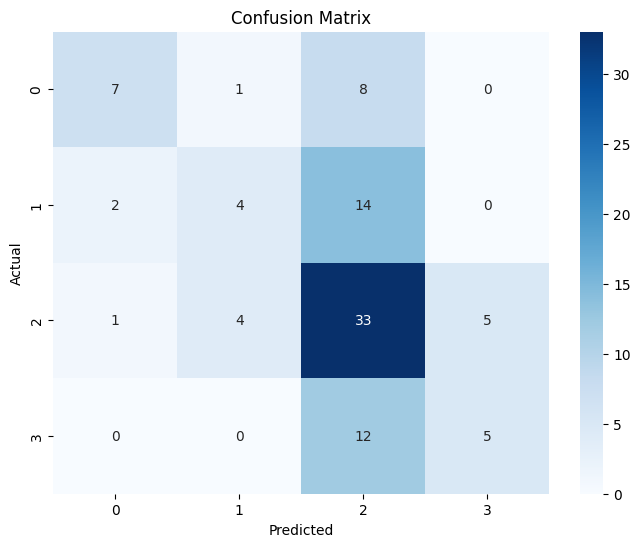

Classification Report:

              precision    recall  f1-score   support

           0       0.70      0.44      0.54        16
           1       0.44      0.20      0.28        20
           2       0.49      0.77      0.60        43
           3       0.50      0.29      0.37        17

    accuracy                           0.51        96
   macro avg       0.53      0.42      0.45        96
weighted avg       0.52      0.51      0.48        96



In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve


# Confusion Matrix
conf_matrix = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print("Classification Report:\n")
print(classification_report(y_val, y_pred))

## Analyze misclassified

In [11]:
misclassified_indices = np.where(y_val != y_pred)[0]
for idx in misclassified_indices[:10]:  # Inspect first 10 misclassified samples
    print(f"Text: {X_val.iloc[idx]}")
    print(f"True Label: {y_val.iloc[idx]}, Predicted Label: {y_pred[idx]}\n")

Text: From symbol of peace to megaphone for war, #Putin rewrites history of #Luzniki stadium
True Label: 3, Predicted Label: 2

Text: Countries supporting #Ukraine do not have the means to track the weapons they send to the Kiev army. And some have already gone to pro-Russian troops in the #Donbass, as some photos show 👇

by @FuturaDaprile

 
True Label: 1, Predicted Label: 2

Text: It's #11thApril! So what?

* Day of war #47 in #Ukraine.
* Austrian PM #Nehammer in Moscow from #Putin.
* #Draghi to #Algiers for #gas deal.
* National #sea day

April 11, 1961 Bob #Dylan's first performance.
True Label: 2, Predicted Label: 3

Text: Russia and Ukraine between Culture and History
Friday, March 18, 2022, 4 p.m. - Room 22, Pescara Campus and Teams Platform
Notice on the Athenaeum website:
True Label: 3, Predicted Label: 2

Text: LA #GUERRA GIUSTA NON ESISTE!
INVOCARE #PACE INVIANDO #ARMI NON È PER L'EROE CHE COMBATTE, MA PER IL POPOLO CHE VIENE MACELLATO!
SIAMO UN PAESE DI COGLIONI INVASATI!
S

## Extract attentions and Q, K and V values

In [19]:
def extract_attention_and_qkv(model, tokenizer, text):
    encoding = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    with torch.no_grad():
        _, attentions, qkv_values = model(input_ids, attention_mask)
    
    return attentions, qkv_values

# Example usage
text = """
#RussiansAreOurBrothers #UkrainiansAreOurBrothers.
"""
attentions, qkv_values = extract_attention_and_qkv(model, tokenizer, text)

# Inspect Q, K, V values for the first layer
q, k, v = qkv_values[0]
print("Query Matrix:", q)
print("Key Matrix:", k)
print("Value Matrix:", v)

Query Matrix: tensor([[[ 0.8083, -1.2506,  0.6449,  ..., -0.1204,  0.0717, -0.3030],
         [ 1.0347, -1.3170,  0.4826,  ...,  0.2415,  1.7141, -0.2618],
         [ 0.4279,  0.2909,  0.5141,  ..., -1.5505,  0.6616, -0.9243],
         ...,
         [-0.1964, -0.1278,  0.3596,  ..., -0.3204,  1.0517,  0.4198],
         [ 0.0621, -1.4907, -0.0973,  ..., -1.4343,  0.2177, -0.3433],
         [ 0.1167, -0.9132,  0.0400,  ..., -1.7297,  0.8673,  0.6689]]],
       device='cuda:0')
Key Matrix: tensor([[[ 0.0719, -0.3336, -0.3582,  ..., -1.0942,  0.0415,  0.3622],
         [-0.3059, -0.3942, -0.5233,  ..., -0.3287, -1.8436,  0.0775],
         [ 0.7658,  0.0162, -0.3563,  ..., -0.7411, -0.4009, -0.3999],
         ...,
         [-0.6890, -0.0168, -0.7978,  ..., -0.0358, -1.1726, -0.2631],
         [ 1.0872,  0.3093, -0.0258,  ...,  0.4344,  0.7714, -0.5284],
         [ 0.6604,  0.5337, -0.5732,  ...,  0.2440, -0.2004, -0.0947]]],
       device='cuda:0')
Value Matrix: tensor([[[ 0.5653,  0.2751, 

In [20]:
print(attentions)

(tensor([[[[0.0000e+00, 2.0992e-02, 1.2816e-02,  ..., 1.4005e-01,
           1.4287e-01, 2.3346e-01],
          [3.7842e-02, 1.0549e-01, 9.6325e-02,  ..., 0.0000e+00,
           4.4265e-02, 3.8771e-02],
          [2.7467e-02, 6.6282e-02, 1.5094e-01,  ..., 2.8537e-02,
           1.9113e-02, 1.1105e-02],
          ...,
          [1.8683e-02, 1.0117e-01, 1.1092e-01,  ..., 2.4623e-02,
           5.4068e-02, 3.6281e-02],
          [6.6168e-02, 8.6819e-02, 3.2157e-02,  ..., 8.7797e-02,
           1.3063e-01, 0.0000e+00],
          [9.6621e-02, 2.8548e-02, 2.4338e-02,  ..., 1.4664e-01,
           1.9873e-01, 6.7494e-02]],

         [[0.0000e+00, 5.8515e-03, 1.1826e-03,  ..., 6.1413e-02,
           4.3363e-02, 3.8637e-03],
          [2.0616e-03, 0.0000e+00, 1.5509e-01,  ..., 1.1314e-02,
           1.1266e-02, 1.3489e-02],
          [4.0135e-02, 4.2083e-02, 1.3141e-01,  ..., 5.8733e-03,
           3.7997e-03, 2.5383e-02],
          ...,
          [1.5934e-01, 5.2917e-02, 5.0120e-02,  ..., 1.946

## Visualizing

### Markdown

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_attention_scores(attentions, layer_idx=0, head_idx=0):
    """
    Plots attention scores for a specific layer and head.
    """
    # Extract attention weights for the specified layer and head
    attention_weights = attentions[layer_idx][0, head_idx].detach().cpu().numpy()  # Shape: (seq_len, seq_len)
    
    # Plot heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(attention_weights, annot=True, fmt=".2f", cmap="viridis")
    plt.title(f"Attention Scores (Layer {layer_idx}, Head {head_idx})")
    plt.xlabel("Keys")
    plt.ylabel("Queries")
    plt.show()

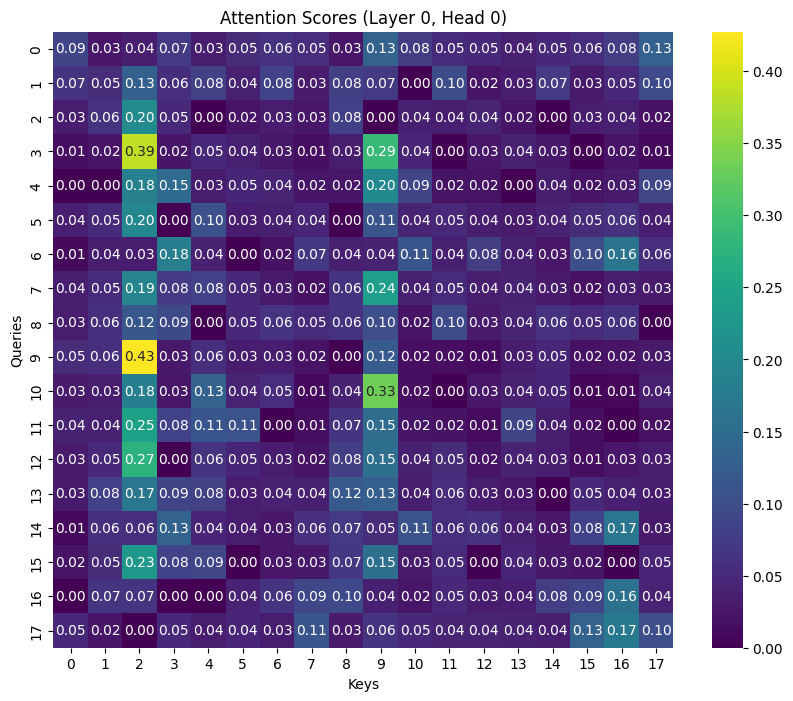

In [31]:

# Plot attention scores for the first layer and first head
plot_attention_scores(attentions, layer_idx=0, head_idx=0)

### Query Values

In [32]:
def plot_query_values(q, tokenized_text, layer_idx=0, head_idx=0):
    """
    Plots query values for a specific layer and head.
    """
    # Extract query values for the specified layer and head
    q_values = q[layer_idx][0, :, head_idx].detach().cpu().numpy()  # Shape: (seq_len,)
    
    # Decode tokenized text
    tokens = tokenizer.convert_ids_to_tokens(tokenized_text['input_ids'][0])
    
    # Plot bar chart
    plt.figure(figsize=(12, 6))
    plt.bar(tokens, q_values, color='skyblue')
    plt.title(f"Query Values (Layer {layer_idx}, Head {head_idx})")
    plt.xlabel("Tokens")
    plt.ylabel("Query Value")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_qkv_matrix_with_tokens(matrix, tokens, title="Matrix", cmap="viridis"):
    """
    Plots a heatmap of the given Q, K, or V matrix with token labels.
    """
    # Convert matrix to numpy array if it's a PyTorch tensor
    if isinstance(matrix, torch.Tensor):
        matrix = matrix.detach().cpu().numpy()
    
    # Plot heatmap
    plt.figure(figsize=(12, 6))
    sns.heatmap(matrix, cmap=cmap, yticklabels=tokens)
    plt.title(title)
    plt.xlabel("Hidden Dimensions")
    plt.ylabel("Tokens")
    plt.tight_layout()
    plt.show()

In [35]:
# Tokenize the input text
text = """
#RussiansAreOurBrothers #UkrainiansAreOurBrothers.
"""
encoding = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)

# Extract tokens
tokens = tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])  # List of tokens
print("Tokens:", tokens)

Tokens: ['[CLS]', '#', 'russians', '##are', '##our', '##bro', '##ther', '##s', '#', 'ukrainian', '##sar', '##eo', '##ur', '##bro', '##ther', '##s', '.', '[SEP]']


In [36]:
# Extract attention scores and Q, K, V values
attentions, qkv_values = extract_attention_and_qkv(model, tokenizer, text)

# Inspect Q, K, V values for the first layer
q, k, v = qkv_values[0]
print("Query Matrix Shape:", q.shape)
print("Key Matrix Shape:", k.shape)
print("Value Matrix Shape:", v.shape)

Query Matrix Shape: torch.Size([1, 18, 768])
Key Matrix Shape: torch.Size([1, 18, 768])
Value Matrix Shape: torch.Size([1, 18, 768])


In [41]:
# Move tensors to CPU and convert to numpy arrays
q_matrix = q[0, 0].detach().cpu().numpy()  # Shape: (seq_len, head_dim)
k_matrix = k[0, 0].detach().cpu().numpy()  # Shape: (seq_len, head_dim)
v_matrix = v[0, 0].detach().cpu().numpy()  # Shape: (seq_len, head_dim)

print("Query Matrix Shape:", q_matrix.shape)
print("Key Matrix Shape:", k_matrix.shape)
print("Value Matrix Shape:", v_matrix.shape)

Query Matrix Shape: (768,)
Key Matrix Shape: (768,)
Value Matrix Shape: (768,)


Tokens: ['[CLS]', '#', 'russians', '##are', '##our', '##bro', '##ther', '##s', '#', 'ukrainian', '##sar', '##eo', '##ur', '##bro', '##ther', '##s', '.', '[SEP]']
Embeddings Shape: torch.Size([1, 18, 768])
Query Matrix Shape: (18, 768)
Key Matrix Shape: (18, 768)
Value Matrix Shape: (18, 768)


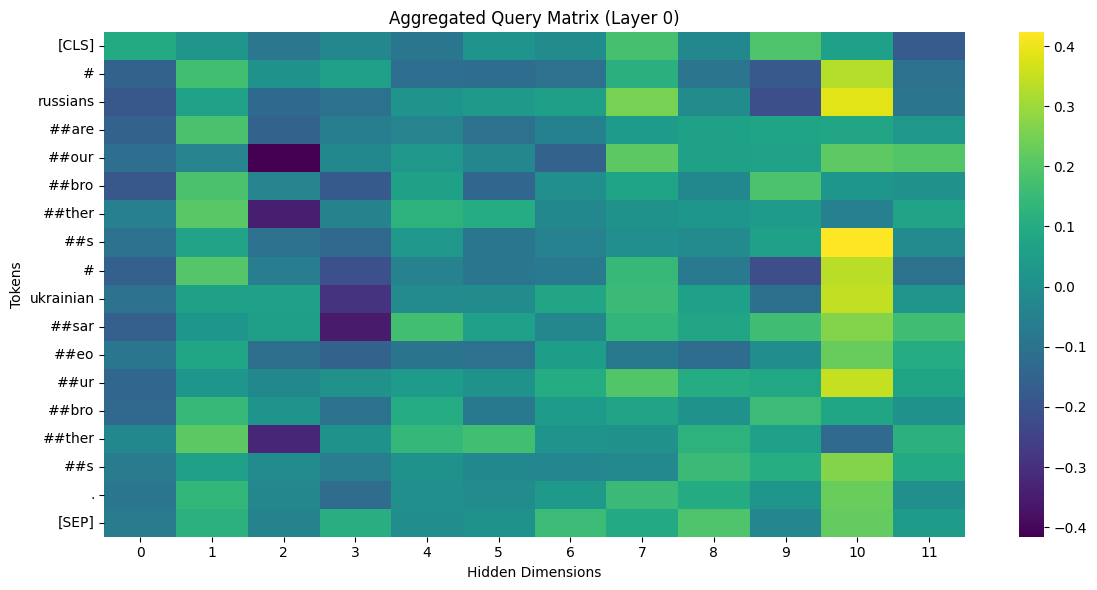

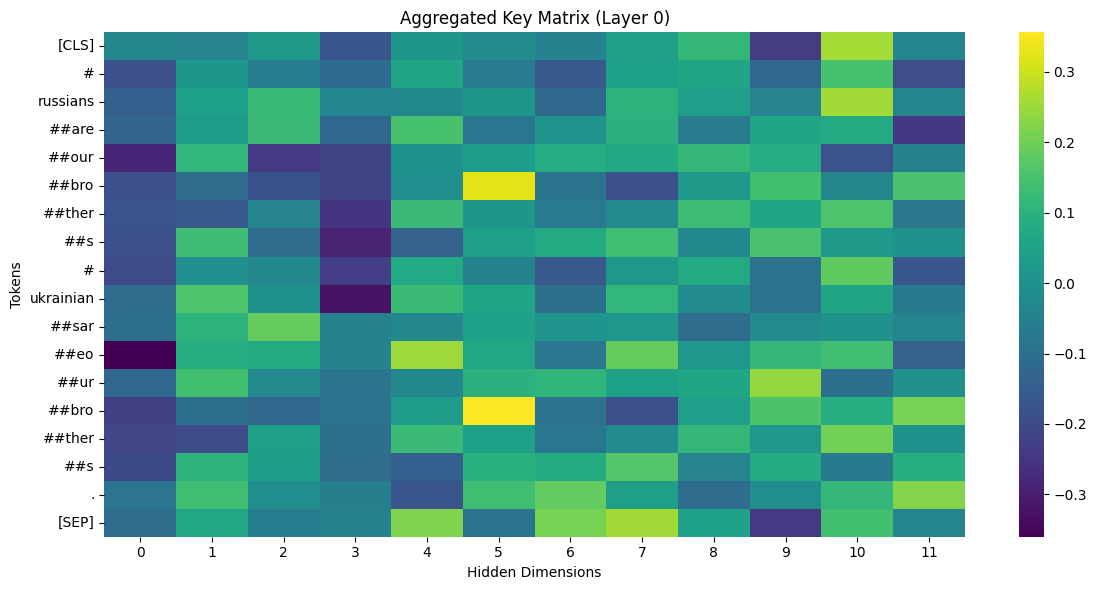

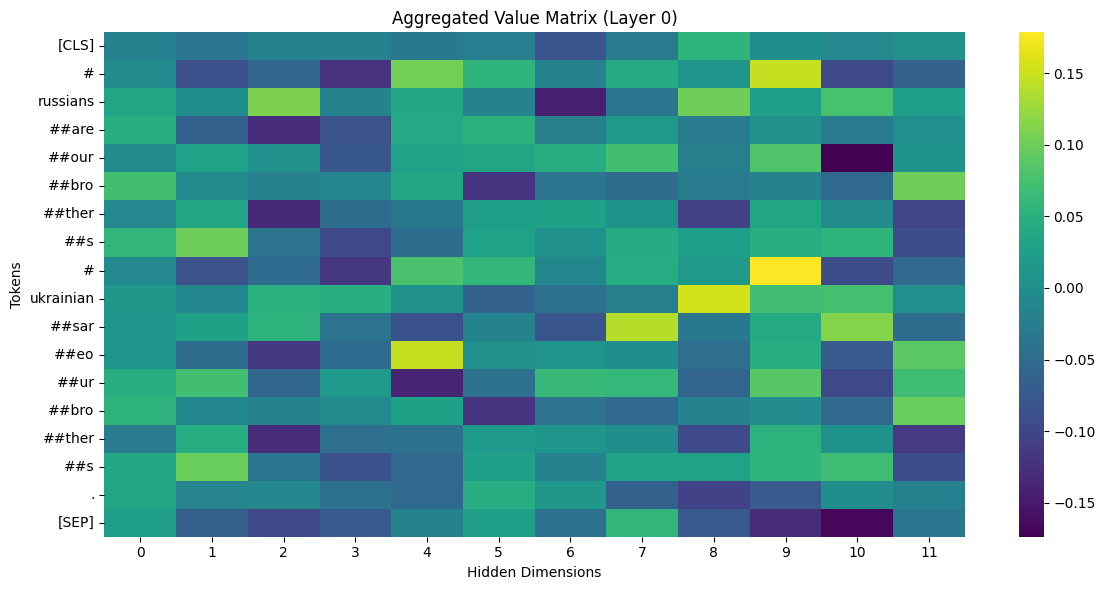

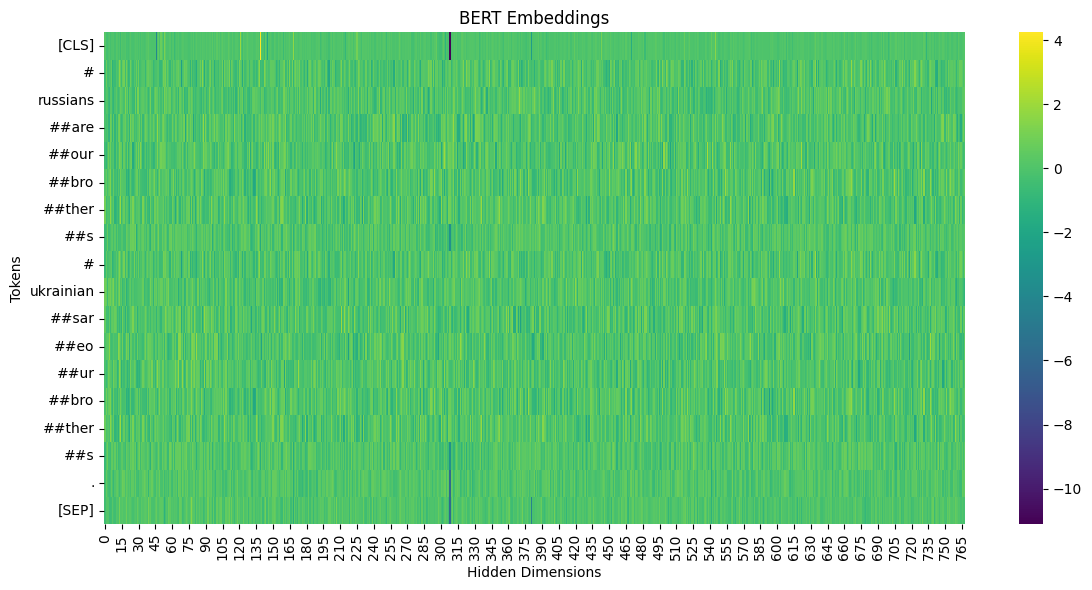

In [52]:
import torch
from transformers import BertModel, BertTokenizer
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Initialize the tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased', output_attentions=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Tokenize the input text
text = """
#RussiansAreOurBrothers #UkrainiansAreOurBrothers.
"""
encoding = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
input_ids = encoding['input_ids'].to(device)  # Shape: (batch_size, seq_len)
attention_mask = encoding['attention_mask'].to(device)  # Shape: (batch_size, seq_len)

# Extract tokens for visualization
tokens = tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])  # List of tokens
print("Tokens:", tokens)

# Generate embeddings using BERT's embedding layer
with torch.no_grad():
    embeddings = model.embeddings(input_ids=input_ids)  # Shape: (batch_size, seq_len, hidden_dim)

print("Embeddings Shape:", embeddings.shape)  # Expected: (1, seq_len, 768)

# Project embeddings into Query, Key, and Value vectors
with torch.no_grad():
    # Get the first layer's attention mechanism
    layer = model.encoder.layer[0].attention.self
    q = layer.query(embeddings)  # Query projection
    k = layer.key(embeddings)    # Key projection
    v = layer.value(embeddings)  # Value projection

    # Move tensors to CPU and convert to numpy arrays
    q_matrix = q[0].detach().cpu().numpy()  # Shape: (seq_len, head_dim * num_heads)
    k_matrix = k[0].detach().cpu().numpy()  # Shape: (seq_len, head_dim * num_heads)
    v_matrix = v[0].detach().cpu().numpy()  # Shape: (seq_len, head_dim * num_heads)

print("Query Matrix Shape:", q_matrix.shape)  # Expected: (seq_len, 768)
print("Key Matrix Shape:", k_matrix.shape)   # Expected: (seq_len, 768)
print("Value Matrix Shape:", v_matrix.shape) # Expected: (seq_len, 768)

# Function to aggregate the head_dim dimension
def aggregate_head_dim(matrix, num_heads=12):
    """
    Aggregates the head_dim dimension by taking the mean across each head.
    """
    matrix = matrix.reshape(-1, num_heads, matrix.shape[-1] // num_heads)  # Reshape to (seq_len, num_heads, head_dim)
    return np.mean(matrix, axis=-1)  # Shape: (seq_len, num_heads)

# Function to plot matrices with token labels
def plot_matrix(matrix, tokens, title="Matrix", cmap="viridis"):
    """
    Plots a heatmap of the given matrix with token labels.
    """
    # Ensure the number of rows in the matrix matches the number of tokens
    if matrix.shape[0] != len(tokens):
        raise ValueError(f"Mismatch between matrix rows ({matrix.shape[0]}) and tokens ({len(tokens)})")
    
    # Plot heatmap
    plt.figure(figsize=(12, 6))
    sns.heatmap(matrix, cmap=cmap, yticklabels=tokens)
    plt.title(title)
    plt.xlabel("Hidden Dimensions" if matrix.shape[1] > 1 else "Aggregated/Reduced Dimension")
    plt.ylabel("Tokens")
    plt.tight_layout()
    plt.show()

# Aggregate the head_dim dimension
q_matrix_agg = aggregate_head_dim(q_matrix)
k_matrix_agg = aggregate_head_dim(k_matrix)
v_matrix_agg = aggregate_head_dim(v_matrix)

# Plot aggregated matrices
plot_matrix(q_matrix_agg, tokens, title="Aggregated Query Matrix (Layer 0)")
plot_matrix(k_matrix_agg, tokens, title="Aggregated Key Matrix (Layer 0)")
plot_matrix(v_matrix_agg, tokens, title="Aggregated Value Matrix (Layer 0)")

# Plot embeddings
embeddings_matrix = embeddings[0].detach().cpu().numpy()  # Shape: (seq_len, 768)
plot_matrix(embeddings_matrix, tokens, title="BERT Embeddings")